# Poisson Distribution: Counting
Reference: https://www.itl.nist.gov/div898/handbook/eda/section3/eda366j.htm

In [1]:
# python version
import sys
sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

#sns.set()

In [3]:
means = [1.56, 0.35]

In [4]:
poisson = [stats.poisson(m) for m in means]

In [5]:
n = np.arange(0, 10)
pmfs = [p.pmf(n) for p in poisson]

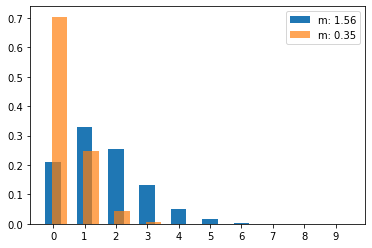

In [6]:
shift = [0, 0.2]
alpha = [1, 0.7]
label = [f'm: {m}' for m in means]
for i, p in enumerate(pmfs):
    plt.bar(n+shift[i], p, alpha=alpha[i], width=.5, label=label[i]) 
    plt.xticks(n)
plt.legend();

In [7]:
# see how mean estimator changes from sample to sample
def dosim(prob, nsamples, Nsim=100): 
    m = np.empty(Nsim)
    for i in range(Nsim):
        s = prob.rvs(nsamples)
        m[i] = s.mean()
    return np.array(m)

In [8]:
itertools.zip_longest

itertools.zip_longest

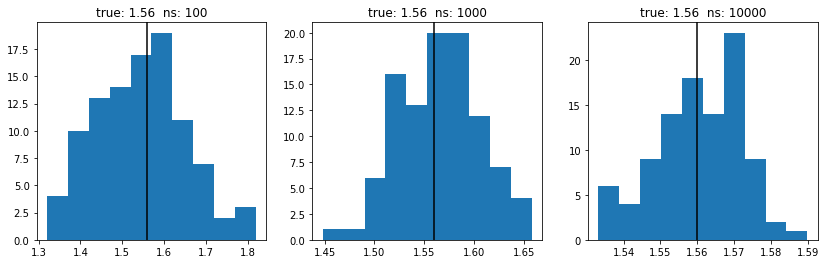

In [9]:
nsamples = [100, 1000, 10000]
tm = means[0]
mss = [dosim(poisson[0], nsamples=ns) for ns in nsamples]
fig, axes = plt.subplots(1,len(nsamples), figsize=(14,4))
for ax, ms, ns in itertools.zip_longest(axes, mss, nsamples):
    ax.hist(ms);
    ax.set_title(f'true: {tm}  ns: {ns}');
    ax.axvline(tm, color='k');

In [10]:
# make a random sample
samples = np.array([ p.rvs(100) for p in poisson])
samples.mean(axis=1)

array([1.48, 0.25])

In [11]:
import pymc3 as pm
import arviz as az

pm.__version__

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


'3.9.3'

### Let's model the mean values as PDF

In [12]:
with pm.Model() as pmodel:
    m1 = pm.Uniform('m1', lower=0, upper=3)
    like1 = pm.Poisson('obs1', mu=m1, observed=samples[0])
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8809755854965635, but should be close to 0.8. Try to increase the number of tuning steps.


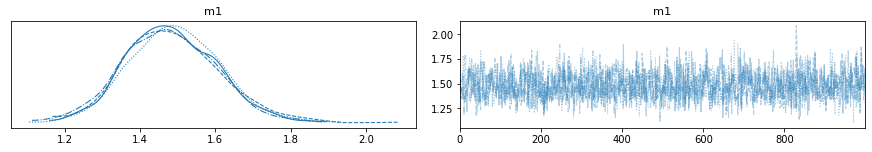

In [13]:
with pmodel:
    pm.traceplot(trace)

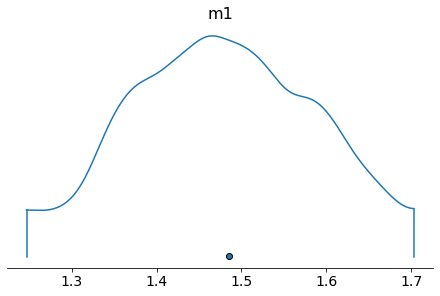

In [14]:
with pmodel:
    az.plot_density(trace)

In [15]:
(trace['m1'] == 0.0).sum()

0

### Bayesian Computational Method

In [16]:
with pm.Model() as model:
    p1 = pm.Poisson("gd", mu=1.56)
    p2 = pm.Poisson('gb', mu=0.35)
    
    diff = pm.Deterministic('diff', p1 - p2)
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [gb]
>Metropolis: [gd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [17]:
trace.varnames

['gd', 'gb', 'diff']

In [18]:
trace['gd'].shape

(4000,)

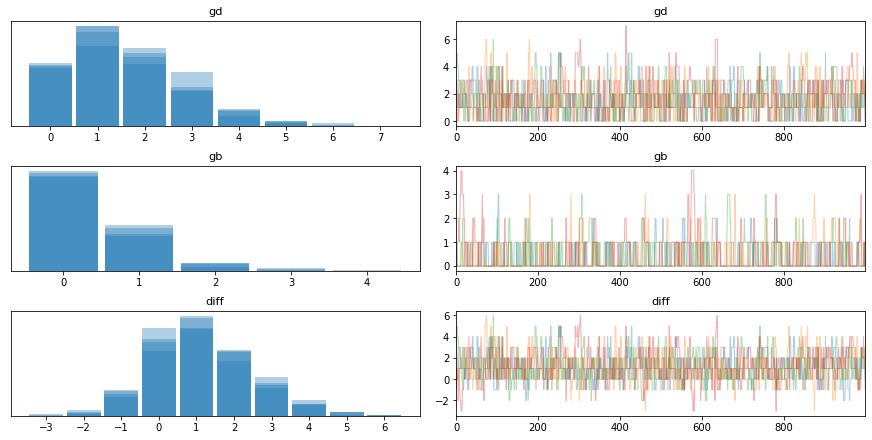

In [19]:
with model:
    pm.plot_trace(trace)

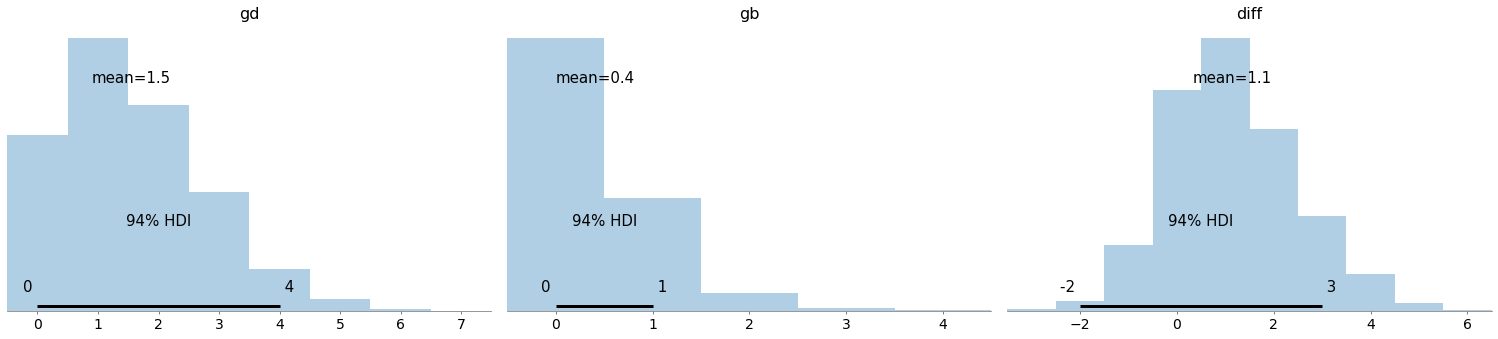

In [20]:
with model:
    pm.plot_posterior(trace)

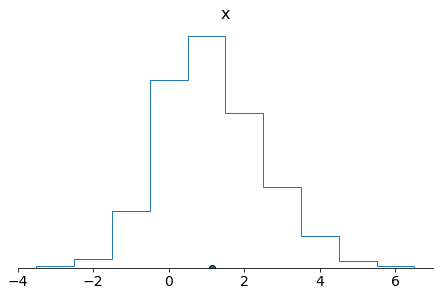

In [21]:
with model:
    az.plot_density(trace['diff'], )

In [22]:
trace?

Type:        MultiTrace
String form: <MultiTrace: 4 chains, 1000 iterations, 3 variables>
Length:      1000
File:        ~/.local/lib/python3.6/site-packages/pymc3/backends/base.py
Docstring:  
Main interface for accessing values from MCMC results.

The core method to select values is `get_values`. The method
to select sampler statistics is `get_sampler_stats`. Both kinds of
values can also be accessed by indexing the MultiTrace object.
Indexing can behave in four ways:

1. Indexing with a variable or variable name (str) returns all
   values for that variable, combining values for all chains.

   >>> trace[varname]

   Slicing after the variable name can be used to burn and thin
   the samples.

   >>> trace[varname, 1000:]

   For convenience during interactive use, values can also be
   accessed using the variable as an attribute.

   >>> trace.varname

2. Indexing with an integer returns a dictionary with values for
   each variable at the given index (corresponding to a single
   